In [1]:
# Ignore cuDDa warning messages
import warnings
warnings.filterwarnings('ignore')

# Enable GPU
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# # Expands the Jupyter Notebook Output Size to fit your window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load in tensorboard
%load_ext tensorboard

In [2]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [3]:
# print(DMJ.entities_idx)

In [4]:
from tensorflow_models import TF_Models, Ein_Multiply, leaky_relu, rank_loss_func
DMJ = TF_Models('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ/', './ignorable_data/models/[55, 25, 20]_split/', reload=False)
data_splits = DMJ.split_data()

DMJ.Normalized_Adjacency_Matrix = DMJ.Normalized_Adjacency_Matrix[0:880, 0:880]
DMJ.XX_tf = DMJ.XX_tf[0:-1, :, :]
DMJ.YY_tf = DMJ.YY_tf[0:-1, :]
DMJ.RR_tf = DMJ.RR_tf[0:-1, :]
DMJ.entities = DMJ.entities[0:-1]
DMJ.entities_idx.pop('ZUMZ')

model = DMJ.generate_model()

from graph_predictions import Graph_Predictions
GP = Graph_Predictions("./ignorable_data/models/[55, 25, 20]_split/", "./ignorable_data/strategies/RL_validation_strategies/", 'x_val', DMJ)



GridBox(children=(Dropdown(description='Model Types:', options=('lstm', 'lstm_gcn_1', 'lstm_gcn_2', 'lstm_gcn_…

In [5]:
import datetime
import pickle
import sys
from os.path import join, isfile
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.python.ops import math_ops
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Sequential

from explore_entities import Graph_Entities
import ipywidgets as widgets
from ipywidgets import Layout, GridBox
from IPython.display import display
import matplotlib.pyplot as plt

import warnings
import os
import math

from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# What if we split the data into time batches ourselves and trained them?

In [6]:
# Given a total and list of splits, evenly distributes the total amount proportional to the given list
def split_windows(total, percentages_list):
    # Get a sum of the initial total
    percentage_sum = sum(percentages_list)

    # Create a new list based on a percentage of the total
    new_splits = []
    for perc in percentages_list:
        new_splits.append(int(total * (perc / percentage_sum)))
    
    # Where to shift the extra days that don't exactly divide between the values
    if sum(new_splits) != total:
        new_splits[-1] = new_splits[-1] + (total - sum(new_splits))

    return new_splits

# one_x = DMJ.XX_tf[0:2, :, :]
# one_y = DMJ.YY_tf[0:2, :]
one_x = DMJ.XX_tf
print(DMJ.XX_tf.shape)
one_y = DMJ.YY_tf

# one_x = DMJ.XX_tf[0:-1, :, :]
# one_y = DMJ.YY_tf[0:-1, :]

# # Given a dataset, let's section off a fifth of the data to be used for testing purposes
# time_split = [1000, 239,]
# x_train, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
#                                   axis=1)
# y_train, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
#                                   axis=1)
# rr_train, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
#                                      axis=1)

# Given a dataset, let's section off a fifth of the data to be used for testing purposes
time_split = [90, 710, 239, 199]
time_split = [55, 25, 20]

time_split = [30, 25, 25, 20]
x_g, x_train, x_val, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
                                  axis=1)
y_g, y_train, y_val, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
                                  axis=1)
rr_g, rr_train, rr_val, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
                                     axis=1)

# y_train = y_train[:, -1]
# y_val = y_val[:, -1]

# # Once we have the data partitioned, let's split it into 8 sets of 125
# batch_splits = [1]*8
# # Create a list of 8 different time batches
# x_train_batches = []
# x_train_batches.append(tf.split(x_train, split_windows(x_train.shape[1], batch_splits), axis=1))
# x_train_batches = [item for sublist in x_train_batches for item in sublist]

# y_train_batches = []
# y_train_batches.append(tf.split(y_train, split_windows(x_train.shape[1], batch_splits), axis=1))
# y_train_batches = [item for sublist in y_train_batches for item in sublist]

# # Lets try truncating the values for the labels to only be the final value
# for i in range(len(y_train_batches)):
#     y_train_batches[i] = y_train_batches[i][:, -1]

# print(x_train[0, -1, 0])

# print(rr_train[0, -1])

# print(x_val[0, 0, 0])
# print(y_train[0, -1])
# for set in [x_train, x_g, x_val, x_test]:
print(x_val.shape)
print(x_train.shape)

print(x_train[0, 0, 0])
print(x_train[0, 1, 0])
print(rr_train[0, 0])

print(x_train[0, -1, 0])
print(x_train[0, -2, 0])
print(x_train[0, -2:-1, 0])

print(keras.Input(shape=(x_train.shape[1], x_train.shape[2])).shape)

(880, 1239, 5)
(880, 309, 5)
(880, 309, 5)
tf.Tensor(0.455917, shape=(), dtype=float32)
tf.Tensor(0.461538, shape=(), dtype=float32)
tf.Tensor(0.012328968, shape=(), dtype=float32)
tf.Tensor(0.425614, shape=(), dtype=float32)
tf.Tensor(0.415741, shape=(), dtype=float32)
tf.Tensor([0.415741], shape=(1,), dtype=float32)
(None, 309, 5)


# Creating and Training an LSTM Model

In [7]:
# from tensorflow_models import mse_rr

# from tensorflow_models import rank_loss_rr
# from tensorflow_models import rank_loss_rr_labels
from tensorflow_models import rank_loss_correct_pred_return_sequences

tf.random.set_seed(1337)

# Creating an LSTM model
optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
            name='Adam'
        )
# Assuming all time steps are the same size, we can just use the first item to determine input shape
input_seq = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
# input_rel = keras.Input(shape=(DMJ.Normalized_Adjacency_Matrix.shape[0]))

# Create a function for the Tensorflow implementation of Tensorflow 2
def leaky_relu(x):
    return tf.keras.layers.LeakyReLU(alpha=0.2)(x)

hidden_units = 64
activation = leaky_relu
do = 0
# x = tf.keras.layers.Masking(mask_value=0.0)(input_seq)
x = LSTM(hidden_units, activation=activation, dropout=do, recurrent_dropout=do, return_sequences=True)(input_seq)
# x = Ein_Multiply()([input_rel, x])
# x = tf.keras.layers.RepeatVector(x_train_batches[0].shape[1])(x)
# x = LSTM(hidden_units, activation=activation, dropout=do)(x)
x = Dense(1, activation=activation)(x)
model = tf.keras.Model(inputs=[input_seq], outputs=x)
# model = tf.keras.Model(inputs=[input_seq, input_rel], outputs=x)

model.compile(loss=rank_loss_correct_pred_return_sequences, optimizer=optimizer)
model.summary()

# model = Sequential()
# model.add(LSTM(hidden_units, activation=activation, input_shape=(x_train_batches[0].shape[1], x_train_batches[0].shape[2])))
# model.add(Dense(1, activation=activation))
# model.compile(optimizer=optimizer, loss='mse')
# model.summary()
losses = []


# #Simple GCN Aggregate
# from tensorflow_models import mse_rr
# from tensorflow_models import rank_loss_rr
# tf.random.set_seed(1337)

# optimizer = tf.keras.optimizers.Adam(
#             learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#             name='Adam'
#         )

# # Create a function for the Tensorflow implementation of Tensorflow 2
# def leaky_relu(x):
#     return tf.keras.layers.LeakyReLU(alpha=0.2)(x)

# hidden_units = 64
# activation = leaky_relu
# do = 0.1
# # Assuming all time steps are the same size, we can just use the first item to determine input shape
# input_seq = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
# input_rel = keras.Input(shape=self.Normalized_Adjacency_Matrix.shape[0])


# # Load in an already trained LSTM Model
# file_name = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA'
# model_path = './ignorable_data/models/[55, 25, 20]_split/'
# pre_trained_lstm = tf.keras.models.load_model(model_path + f'{file_name}', compile=False,
#                                               custom_objects={'leaky_relu': leaky_relu})

# # Change the names to avoid conflicts
# pre_trained_lstm.layers[0]._name = 'InputLayer'
# pre_trained_lstm.layers[1]._name = 'LSTM'
# pre_trained_lstm.layers[2]._name = 'Dense'

# # This is the LSTM layer
# x = pre_trained_lstm.layers[1](input_seq)
# # This is one aggregation using the NAM
# x = Ein_Multiply()([input_rel, x])
# # THis
# x = pre_trained_lstm.layers[2](x)

# # x = Ein_Multiply()([input_rel, x])
# # # x = Dense(hidden_units, activation=activation)(x)
# # # x = Ein_Multiply()([input_rel, x])
# # # x = Dense(hidden_units, activation=activation)(x)
# # x = Dense(1, activation=activation)(x)
# # model = tf.keras.Model(inputs=[input_seq, input_rel], outputs=x)

# # # Make sure that the weights for the lstm model cannot be updated
# # # self.model.layers[1].trainable = False
# # # self.model.layers[3].trainable = False

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 309, 5)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 309, 64)           17920     
_________________________________________________________________
dense (Dense)                (None, 309, 1)            65        
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


# Loading in an already trained LSTM model & Adding 1 Graphical Aggregation

In [ ]:
from tensorflow_models import mse_rr
from tensorflow_models import rank_loss_rr
tf.random.set_seed(1337)

optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
            name='Adam'
        )

# x_train = x_train[:, 0:306, :]
# x_val = x_val[:, 0:306, :]

# Create a function for the Tensorflow implementation of Tensorflow 2
def leaky_relu(x):
    return tf.keras.layers.LeakyReLU(alpha=0.2)(x)

hidden_units = 64
activation = leaky_relu
do = 0
# Assuming all time steps are the same size, we can just use the first item to determine input shape
input_seq = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
input_rel = keras.Input(shape=(DMJ.Normalized_Adjacency_Matrix.shape[0]))


# Load in an already trained LSTM Model
file_name = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA'
model_path = './ignorable_data/models/[55, 25, 20]_split/'
pre_trained_lstm = tf.keras.models.load_model(model_path + f'{file_name}', compile=False,
                                              custom_objects={'leaky_relu': leaky_relu})

# Change the names to avoid conflicts
pre_trained_lstm.layers[0]._name = 'InputLayer'
pre_trained_lstm.layers[1]._name = 'LSTM'
pre_trained_lstm.layers[2]._name = 'Dense'

# # Make sure that the weights for the lstm model cannot be updated
pre_trained_lstm.layers[0].trainable = False
pre_trained_lstm.layers[1].trainable = False
pre_trained_lstm.layers[2].trainable = False

# This is the LSTM layer
x = pre_trained_lstm.layers[1](input_seq)
# This is one aggregation using the NAM
# x = Ein_Multiply()([input_rel, x])


# # This is one aggregation using the NAM
# x = Ein_Multiply()([input_rel, x])
x = Dense(hidden_units, activation=activation)(x)


# This is the original Dense Layer
x = pre_trained_lstm.layers[2](x)
# x = Dense(1, activation=activation)(x)

# # x = Dense(hidden_units, activation=activation)(x)
# # x = Ein_Multiply()([input_rel, x])
# # x = Dense(hidden_units, activation=activation)(x)
# x = Dense(1, activation=activation)(x)
# model = tf.keras.Model(inputs=[input_seq, input_rel], outputs=x)
model = tf.keras.Model(inputs=[input_seq, input_rel], outputs=x)

losses = []

In [ ]:
# View what we just created
# model.compile(loss=rank_loss_rr, optimizer=optimizer)
model.compile(loss='mse', optimizer=optimizer)
model.summary()

Epoch 1/10
10/10 [==============================] - 9s 917ms/step - loss: 1.0186 - val_loss: 1.0677
Epoch 2/10
10/10 [==============================] - 9s 904ms/step - loss: 1.0173 - val_loss: 1.0691
Epoch 3/10
10/10 [==============================] - 9s 907ms/step - loss: 1.0192 - val_loss: 1.0669
Epoch 4/10
10/10 [==============================] - 9s 912ms/step - loss: 1.0163 - val_loss: 1.0678
Epoch 5/10
10/10 [==============================] - 9s 913ms/step - loss: 1.0162 - val_loss: 1.0639
Epoch 6/10
10/10 [==============================] - 9s 915ms/step - loss: 1.0163 - val_loss: 1.0636
Epoch 7/10
10/10 [==============================] - 9s 934ms/step - loss: 1.0147 - val_loss: 1.0626
Epoch 8/10
10/10 [==============================] - 9s 913ms/step - loss: 1.0154 - val_loss: 1.0641
Epoch 9/10
10/10 [==============================] - 9s 910ms/step - loss: 1.0157 - val_loss: 1.0642
Epoch 10/10
10/10 [==============================] - 9s 914ms/step - loss: 1.0124 - val_loss: 1.0606

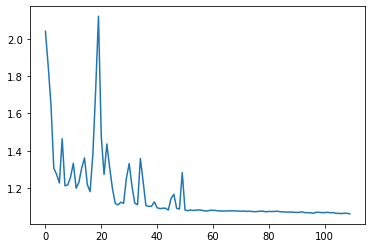

In [10]:
tf.config.run_functions_eagerly(True)

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)

def scheduler(epoch, lr):
    return 0.0002

inputs_train = [x_train]
train_labels = y_train

inputs_val = [x_val]
val_labels = y_val

# If we're using the GCN
# inputs_train.append(DMJ.Normalized_Adjacency_Matrix)
# inputs_val.append(DMJ.Normalized_Adjacency_Matrix)

# int(inputs_train.shape[0])

history = model.fit(inputs_train, train_labels, batch_size=int(inputs_train[0].shape[0]/10),
                              epochs=10, validation_data=(inputs_val, val_labels),
                   callbacks=[model_checkpoint_callback,
                             tf.keras.callbacks.LearningRateScheduler(scheduler,
                                                                      verbose=0)])

model.load_weights(checkpoint_filepath)

for h in history.history['val_loss']:
    losses.append(h)
plt.plot(losses)

In [ ]:
# model.predict([x_train, DMJ.Normalized_Adjacency_Matrix], batch_size=880)
model_save = model

In [ ]:
# for h in history.history['val_loss']:
#     losses.append(h)
# plt.plot(losses)

DMJ.Normalized_Adjacency_Matrix.shape

In [11]:
DMJ.model = model
DMJ.model_name = "3-26-21-1_[25,25,20]CorrAlpha50000_50Epoch_88BatchSize_return_seq"
DMJ.save_model()

'None--0Epochs-None-Loss-None-HU-'

In [18]:
# model_name = "2-16-21-Seq1LSTM-F-64HU-[800,239,200]split-full_y"
# new_directory = './ignorable_data/prediction_results/[55, 25, 20]_splits/'
# GP.generate_validation_prediction_json_SplitBatch_nofeat(model_name, new_directory, x_g, x_val, sliding_window=30)
# GP.generate_validation_prediction_json_SplitBatch_close_gap(model_name, new_directory, x_g, x_val, sliding_window=30)
model_name = '3-26-21-1_[25,25,20]CorrAlpha1000_60Epoch_88BatchSize_return_seq'
model_dir = './ignorable_data/models/[55, 25, 20]_split'
# model_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\models'
past = x_train
future = x_val
# new_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions\pc_version'
new_dir = './ignorable_data/prediction_results/[55, 25, 20]_splits/'
sliding_window = x_val.shape[1]

window = x_train.shape[1]

# GP.generate_predictions(model_name, model_dir, past, future, new_dir, window, model_type='gcn', batch_size=880)
GP.generate_predictions(model_name, model_dir, past, future, new_dir, window, model_type='lstm', batch_size=880)
# GCN_output = GP.return_embeddings(model_name, model_dir, past, future, new_dir, w, model_type='gcn')
# embeddings = GP.return_embeddings(model_name, model_dir, past, future, new_dir, window, model_type='gcn')

#     model_name = '2-20-21-1_LSTM_[25,25,20]_NoDropout_35Epoch_80BatchSize_IncreasedVariedLR_RRMSE'
#     GP.generate_predictions(model_name, model_dir, past, future, new_dir, w)
# GP.generate_validation_prediction_json_SplitBatch(model_name, new_dir, x_g, x_val, sliding_window=sliding_window)


Loading Model: '3-26-21-1_[25,25,20]CorrAlpha1000_60Epoch_88BatchSize_return_seq'
Total number of days: 308
Day 1 | Day 2 | Day 3 | Day 4 | Day 5 | Day 6 | Day 7 | Day 8 | Day 9 | Day 10 | Day 11 | Day 12 | Day 13 | Day 14 | Day 15 | Day 16 | Day 17 | Day 18 | Day 19 | Day 20 | Day 21 | Day 22 | Day 23 | Day 24 | Day 25 | Day 26 | Day 27 | Day 28 | Day 29 | Day 30 | Day 31 | Day 32 | Day 33 | Day 34 | Day 35 | Day 36 | Day 37 | Day 38 | Day 39 | Day 40 | Day 41 | Day 42 | Day 43 | Day 44 | Day 45 | Day 46 | Day 47 | Day 48 | Day 49 | Day 50 | Day 51 | Day 52 | Day 53 | Day 54 | Day 55 | Day 56 | Day 57 | Day 58 | Day 59 | Day 60 | Day 61 | Day 62 | Day 63 | Day 64 | Day 65 | Day 66 | Day 67 | Day 68 | Day 69 | Day 70 | Day 71 | Day 72 | Day 73 | Day 74 | Day 75 | Day 76 | Day 77 | Day 78 | Day 79 | Day 80 | Day 81 | Day 82 | Day 83 | Day 84 | Day 85 | Day 86 | Day 87 | Day 88 | Day 89 | Day 90 | Day 91 | Day 92 | Day 93 | Day 94 | Day 95 | Day 96 | Day 97 | Day 98 | Day 99 | Day 100 |

In [ ]:
# Given the training set, these are the validation values that are output from the LSTM model
print(embeddings.shape)

# This is the NAM that we are using to aggregate the embedding results
print(DMJ.Normalized_Adjacency_Matrix[6,6])

# This should be the aggregated values output from using the NAM (The dimensions look fine)
# new_embeddings = tf.einsum('ntd,nm->mtd', embeddings, DMJ.Normalized_Adjacency_Matrix)
new_embeddings = tf.einsum('mn,ntd->mtd', DMJ.Normalized_Adjacency_Matrix, embeddings)
print(new_embeddings.shape)

print(embeddings[0, -7, 0:10])
# print(embeddings[0, -1, 0:10])
print('  ')
print(new_embeddings[0, -7, 0:10])
# print(new_embeddings[0, -1, 0:10])

# print(tf.subtract(embeddings[0, -2, 0:10], embeddings[0, -1, 0:10]))
# print(tf.subtract(new_embeddings[0, -2, 0:10], new_embeddings[0, -1, 0:10]))

In [ ]:
# Above are the output embeddings of the LSTM layer
# Below is 1 output prediction for a simple NAM Aggregate added to a pre-trained LSTM
GCN_output.shape

In [25]:
p_file_name = '3-26-21-1_[25,25,20]CorrAlpha50000_50Epoch_88BatchSize_return_seq309win_309past_309fut'
p_file_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits'
# p_file_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions\pc_version'
future = x_val
new_dir = './ignorable_data/datablocks/[55, 25, 20]_splits/'
close_gap = False

use_argmin = False
yesterday_pred = False
GP.generate_prediction_results(p_file_name, p_file_dir, future, new_dir, close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred, rr_labels=False)

for root, dirs, files in os.walk(r'C:\Users\Maxwell\PycharmProjects\TAMU-ECEN-403-IFPTSND\ECEN_403_IFM\TAMU-ECEN-403-IFPTSND\ignorable_data\datablocks\[55, 25, 20]_splits'):
    for filename in files:
#         GP.generate_prediction_results(filename, p_file_dir, future, new_dir, close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred)
        GP.add_daily_value_to_datablock(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        GP.add_daily_value_to_datablock_discontinuous(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        GP.add_cumulative_return_ratio_discontinuous(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        None


# use_argmin = True
# yesterday_pred = False
# GP.generate_prediction_results(p_file_name, p_file_dir, future, new_dir, close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred)
# # GP.generate_model_diagnostics_given_sets(p_file_dir + f'/{p_file_name}', future, datablock_folder=new_dir, try_all_pred=False)

MDGL
DGII
BIIB
SPWR
TSRO


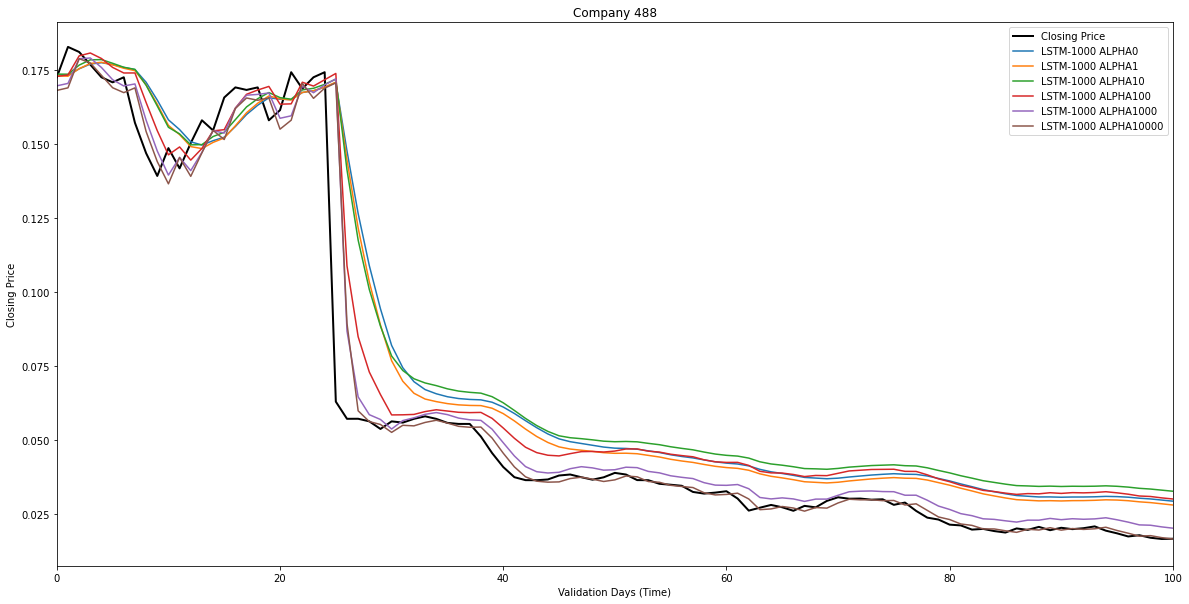

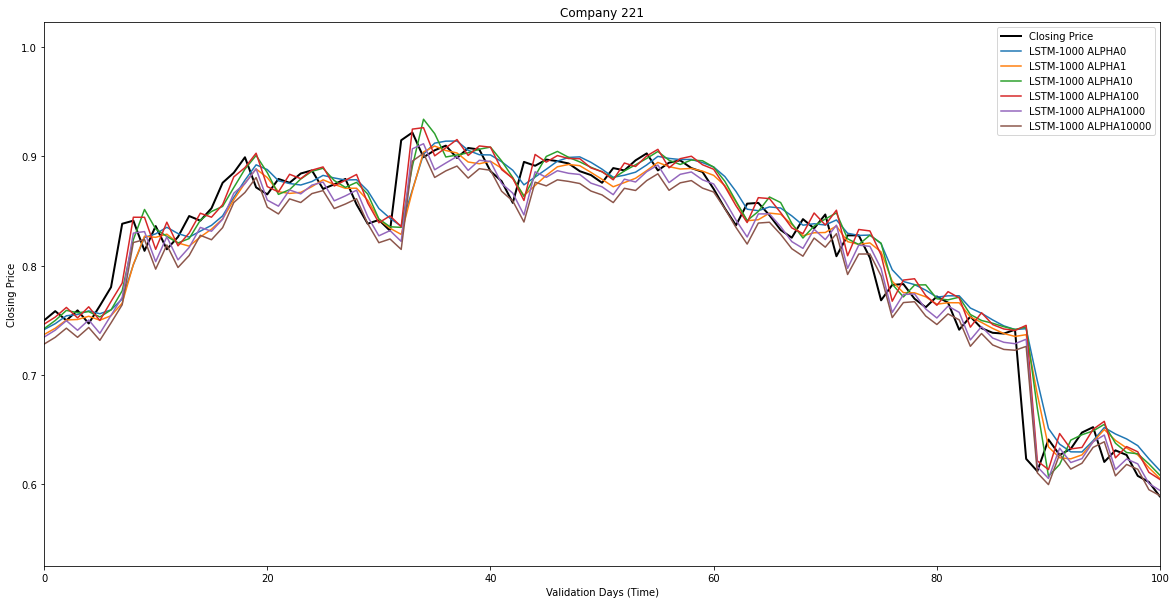

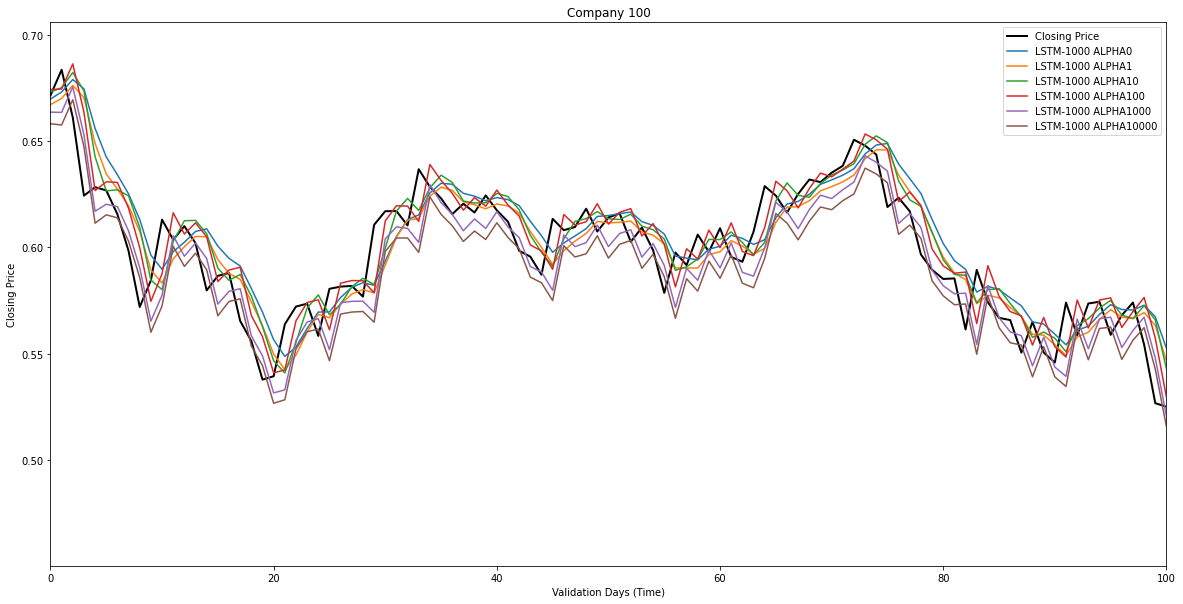

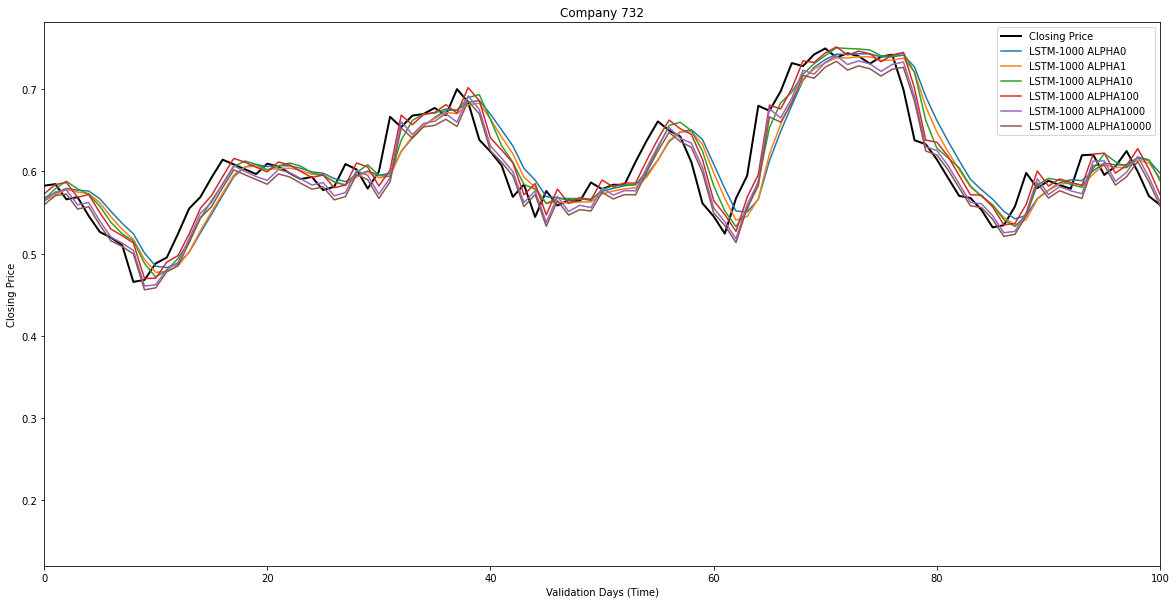

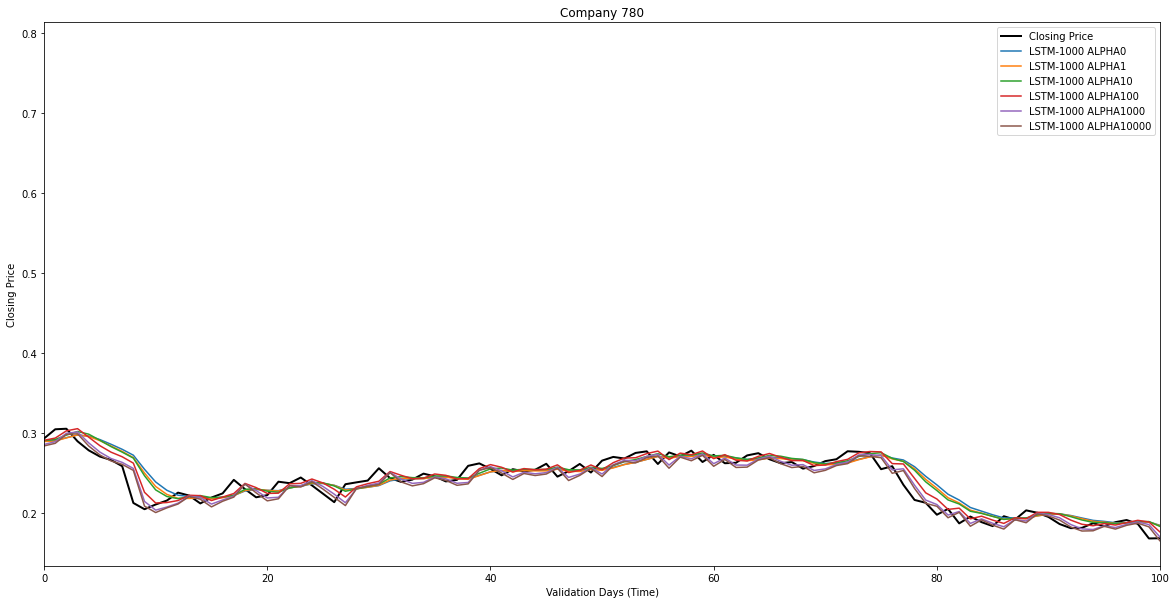

In [34]:
def plot_company(n):
    # n = 597
#     n = 488
    # n = 161
    # n = 561
    # n = 440
    # n = 200
    # # Argmin
    # n = 780

    # n = 876
    # n = 110
    r = 1
    # n = 100
    # n=0

    r=1
    fig, ax = plt.subplots(figsize=(20, 10))
#     ax.set_ylim([0,1])
    ax.set_xlim([0,100])

    time = tf.concat([x_train, x_val, x_test], axis=1)

    # ax = fig.add_subplot()
    for i in range(r):
    #     print(f'{i+n*r} ', end='')
    #     ax.plot(time[i+n*r, :, 0])
        ax.plot(x_val[i+n*r, :, 0], label='Closing Price', linewidth=2, color='black')
    #     ax.plot(rr_val[i+n*r, :], label='Return Ratio')

    ax.plot(A[:, i+n*r], label='LSTM-1000 ALPHA0')
    ax.plot(B[:, i+n*r], label='LSTM-1000 ALPHA1')
    ax.plot(C[:, i+n*r], label='LSTM-1000 ALPHA10')
    ax.plot(D[:, i+n*r], label='LSTM-1000 ALPHA100')
    ax.plot(E[:, i+n*r], label='LSTM-1000 ALPHA1000')
    ax.plot(F[:, i+n*r], label='LSTM-1000 ALPHA10000')
#     ax.plot(G[:, i+n*r], label='LSTM-1000 ALPHA50000')
#     ax.plot(G[:, i+n*r], label='30')
#     ax.plot(H[:, i+n*r], label='60')
#     ax.plot(I[:, i+n*r], label='125')
#     ax.plot(J[:, i+n*r], label='250')
#     ax.plot(K[:, i+n*r], label='500')
    ax.legend()
    ax.set_xlabel('Validation Days (Time)')
    ax.set_ylabel('Closing Price')
    ax.set_title(f'Company {i+n*r}')

    print(DMJ.entities[n])



plot_company(488)
plot_company(221)
plot_company(100)
plot_company(732)
plot_company(780)

In [28]:
pred_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits/'
pred_file = '3-26-21-1_[25,25,20]CorrAlpha0_50Epoch_88BatchSize_return_seq309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
A = GP.test_obj

pred_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits/'
pred_file = '3-26-21-1_[25,25,20]CorrAlpha1_60Epoch_88BatchSize_return_seq309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
B = GP.test_obj

pred_file = '3-26-21-1_[25,25,20]CorrAlpha10_50Epoch_88BatchSize_return_seq309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
C = GP.test_obj

pred_file = '3-26-21-1_[25,25,20]CorrAlpha100_50Epoch_88BatchSize_return_seq309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
D = GP.test_obj

pred_file = '3-26-21-1_[25,25,20]CorrAlpha1000_60Epoch_88BatchSize_return_seq309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
E = GP.test_obj

pred_file = '3-26-21-1_[25,25,20]CorrAlpha10000_50Epoch_88BatchSize_return_seq309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
F = GP.test_obj

pred_file = '3-26-21-1_[25,25,20]CorrAlpha50000_50Epoch_88BatchSize_return_seq309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
G = GP.test_obj

# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-125win_681past_309fut'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# I = GP.test_obj

# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-250win_681past_309fut'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# J = GP.test_obj

# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-500win_681past_309fut'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# K = GP.test_obj
# ##################################################################################################################

# pred_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions/'
# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# A = GP.test_obj

# # pred_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits/'
# pred_file = '02-17-2021--07--37-1LSTM-F-1ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# B = GP.test_obj

# pred_file = '02-17-2021--07--54-1LSTM-F-10.0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# C = GP.test_obj

# pred_file = '02-17-2021--08--11-1LSTM-F-100.0ALPHA-[55,25,20]split-[None, 1]-30Epochs-rlf-Loss-64-HU-'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# D = GP.test_obj

# pred_file = '02-17-2021--08--29-1LSTM-F-1000.0ALPHA-[55,25,20]split-[None, 1]-20Epochs-rlf-Loss-64-HU-'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# E = GP.test_obj

Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions


In [ ]:
# # pred_dir = r"G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions/"
# pred_dir = r".\ignorable_data\prediction_results\[55, 25, 20]_splits/"
# pred_file = '3-11-21-1_LSTM_[25,25,20]_60Epoch_40BatchSize_100ALPHA_RR_Labels309win_309past_309fut_220predBatch'
# GP.generate_model_diagnostics(pred_dir + pred_file, datablock_folder='./ignorable_data/datablocks/', rr_labels=True)
# # GP.generate_model_diagnostics_given_sets_close_gap(pred_dir + pred_file, x_val, datablock_folder='./ignorable_data/datablocks/', try_all_pred=False)

In [26]:
GP.compare_data_blocks('.\ignorable_data\datablocks\[55, 25, 20]_splits')

interactive(children=(Text(value='', description='Search', placeholder='Tag'), Output()), _dom_classes=('widge…

In [ ]:
import json
# Let's look at our relations_file real quick
with open('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ/updated_relations.json') as read_file:
    relations_dict = json.load(read_file)

In [ ]:
print(len(relations_dict.keys()))

In [ ]:
print(DMJ.Normalized_Adjacency_Matrix.shape)
s = 0
for i in DMJ.Normalized_Adjacency_Matrix[89]:
    s = i + s

print(s)